# What has Happened to my Patient since I last saw them?
- Generate Notes ( in generate_list_of_doctors_notes)

Workflow:  
- Get the notes from central repository
- Store in dictionary





In [1]:
import random
import datetime

import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


import os
import re
import openai
import webbrowser
import json
from json import loads, dumps
from docx import Document

import csv
import ast 
import subprocess

import logging #https://www.machinelearningplus.com/python/python-logging-guide/


from chatGPT_utilities import setup_OpenAI_API
from chatGPT_utilities import json_to_dict
from chatGPT_utilities import pp_json
from chatGPT_utilities import get_completion
from chatGPT_utilities import get_completion_from_messages_FULL
from chatGPT_utilities import get_completion_from_messages_FULL_and_costs
from chatGPT_utilities import get_completion_from_messages
from chatGPT_utilities import read_file
from chatGPT_utilities import token_usage
from chatGPT_utilities import print_token_usage
from chatGPT_utilities import openai_object_to_dict
from chatGPT_utilities import read_patient_notes
# from chatGPT_utilities import write_prompt_and_response_DOCX



# from what_happened_utils import who_are_the_Doctors
from what_happened_utils import create_doctor_date_dataframe
from what_happened_utils import generate_list_of_doctors_notes
from what_happened_utils import extract_clinical_data
from what_happened_utils import read_notes
from what_happened_utils import Display_Notes
from what_happened_utils import show_list_of_Doctors_for_pt
from what_happened_utils import scatter_plot_show_dates_notes
from what_happened_utils import find_notes_from_Doctor_X
from what_happened_utils import concatenate_Notes_EXCEPT_Doctor_X


openai.api_key = setup_OpenAI_API()


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Globals

In [2]:
starting_directory = os.getcwd()
random.seed(42)  # Set the random seed for reproducibility
color_map = {
    "Doctor_1": "Red",
    "Doctor_2": "Blue",
    "Doctor_3": "Green",
    "Doctor_4": "Black",
    "Doctor_5": "Orange",
    "Doctor_6": "Purple",
    "Doctor_7": "Pink",
    "Doctor_8": "Cyan",
    "Doctor_9": "Magenta",
    "Doctor_10": "Lime"
}
random.seed(42) # used when generating synthetic data

logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s %(levelname)-8s %(message)s',
                    datefmt='%a, %d  %b %Y %H:%M:%S')
# logging.info('Some information')
# logging.warning('A warning')
# logging.getLogger().setLevel(logging.ERROR)
logging.getLogger().setLevel(logging.DEBUG)
logging.debug('Global variables initialized')

Sat, 15  Jul 2023 08:08:33 DEBUG    Global variables initialized


# Functions
- Who Are The Doctors

In [3]:
pt_notes_dir = 'John_Smith_Notes'
patient_name = 'John_Smith'

pt_notes_dir = 'Jose_Alvarez_Notes'
patient_name = 'Jose_Alvarez'

assert os.getcwd() == starting_directory , 'We should be in starting directory'

dict_of_notes =read_notes(pt_notes_dir,patient_name)
logging.debug(f'Reading {patient_name} ')
list_of_Doctors = show_list_of_Doctors_for_pt(dict_of_notes,patient_name)

Sat, 15  Jul 2023 08:08:33 DEBUG    Reading Jose_Alvarez 


Reading the following files from "Jose Alvarez Notes" :


Reading Jose_Alvarez_2023_06_30.txt  Dr. Doctor_3                        Jun 30, 2023 Initial 
Reading Jose_Alvarez_2023_02_02.txt  Dr. Doctor_5                        Feb 02, 2023 Initial 
Reading Jose_Alvarez_2023_01_30.txt  Dr. Doctor_5                        Jan 01, 2023 Return 
Reading Jose_Alvarez_2023-07-11.txt  Dr. Doctor_1                        Jul 11, 2023 Initial 
Reading Jose_Alvarez_2023_03_30.txt  Dr. Doctor_3                        Mar 30, 2023 Return 


Jose_Alvarez was seen by the following doctors:
  1: Doctor_1
  2: Doctor_3
  3: Doctor_5


# Display Notes

In [4]:
Display_Notes(dict_of_notes,patient_name)



Jose_Alvarez was seen by the following doctors:
  1: Doctor_1
  2: Doctor_3
  3: Doctor_5
Doctor_1
Number of notes by Dr. Doctor_1 : 1 


1. Dr. Doctor_1 saw Jose_Alvarez on 2023-07-11
Note:
Name: Jose Alvarez
Doctor : Doctor_1
Age: 62
Gender: Male
Date of Visit: Jul 11, 2023

Chief Complaint:
Mr. Alvarez presents for annual physical examination

History of Present Illness:
Mr. Alvarez is a 62-year-old male with a known history of chronic obstructive pulmonary disease (COPD), which was diagnosed 10 years ago. He has a significant smoking history of 40 pack-years. Mr. Alvarez reports a progressive increase in dyspnea over the past week, with minimal exertion. He also complains of a productive cough with yellowish sputum. He denies any recent fever, chest pain, or hemoptysis. Mr. Alvarez states that his symptoms have interfered with his daily activities and quality of life.

Past Medical History:

COPD: Diagnosed 10 years ago, classified as GOLD Stage II. He has a history of exacerbati

## Dates of Doctors Notes

In [5]:
list_of_Doctors = show_list_of_Doctors_for_pt(dict_of_notes,
                               patient_name)
df_doctors_notes = create_doctor_date_dataframe(dict_of_notes,
                                                list_of_Doctors)
index_values = list_of_Doctors
multi_index_df = df_doctors_notes.set_index(['Doctor', 'Date']).sort_values(by=['Doctor', 'Date'])
multi_index_df



Jose_Alvarez was seen by the following doctors:
  1: Doctor_1
  2: Doctor_3
  3: Doctor_5


Empty DataFrame
Columns: []
Index: [(Doctor_1, 2023-07-11), (Doctor_3, 2023-03-30), (Doctor_3, 2023-06-30), (Doctor_5, 2023-01-01), (Doctor_5, 2023-02-02)]

## Plot Visit Dates


Empty DataFrame
Columns: []
Index: [(Doctor_1, 2023-07-11), (Doctor_3, 2023-03-30), (Doctor_3, 2023-06-30), (Doctor_5, 2023-01-01), (Doctor_5, 2023-02-02)]

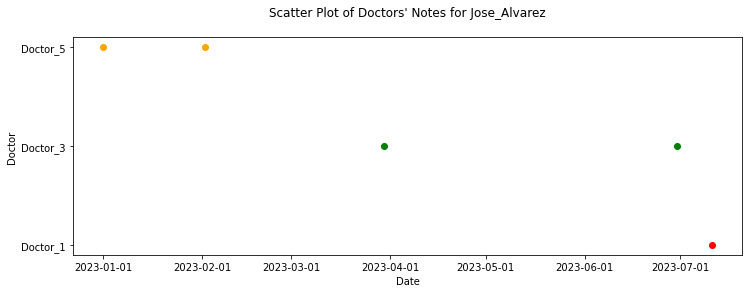

In [7]:
logging.getLogger().setLevel(logging.ERROR)
scatter_plot_show_dates_notes(df_doctors_notes,
                              patient_name,
                              color_map )
multi_index_df


## Find Notes After Date
### Mark a Date on the Chart


- For a given patient, show the notes after a specific date

,Doctor,Date
0,Doctor_5,2023-01-01
1,Doctor_5,2023-02-02
2,Doctor_3,2023-03-30
3,Doctor_3,2023-06-30
4,Doctor_1,2023-07-11


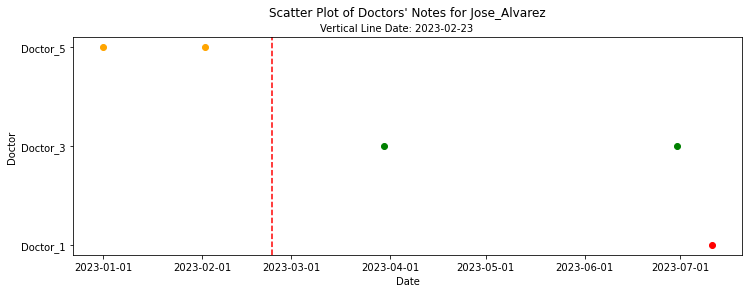

In [7]:
df_doctors_notes = df_doctors_notes.sort_values(['Date','Doctor'], ascending=[True,True])
df_doctors_notes = df_doctors_notes.reset_index(drop=True)
df_doctors_notes
mark_this_date = "Feb 23 2023"
scatter_plot_show_dates_notes(df_doctors_notes,
                              patient_name,
                              color_map,
                              mark_this_date)
# print(df_doctors_notes.columns)


In [8]:
# date_line = "Apr 23 2023"
# find_notes_after_date(list_of_Doctors, date_line)

# # scatter_plot_show_dates_notes(df_doctors_notes, date_line)
# # print(df_doctors_notes.columns)
# # df_doctors_notes = df_doctors_notes.sort_values(['Doctor','Date'], ascending=[True,True])
# # df_doctors_notes = df_doctors_notes.reset_index(drop=True)
# # df_doctors_notes

### Assume you are Doctor X, look for previous notes


In [9]:
            
# def find_notes_from_Doctor_X(dict_of_notes,
#                              name_of_doctor): 
#     # print(dict_of_notes[name_of_doctor]['Notes'])
#     list_of_notes_from_doctor = dict_of_notes[name_of_doctor]['Notes']
#     # print(list_of_notes_from_doctor)
#     num_of_notes = len(list_of_notes_from_doctor)
#     # for note in list_of_notes_from_doctor:
#     #     print(note)

#     sorted_list_of_notes_from_doctor = sorted(list_of_notes_from_doctor, key=lambda x: x["Date"])
        
#     for note in sorted_list_of_notes_from_doctor:

#         print(f"\n\n\n{note['Date']}" )
#         Content =  note['Content'].replace( 'Date of Visit:',\
#                                                '\033[91m'+ '\033[1m' +  'Date of Visit:'+ '\033[0m')
#         # print(f"\t\t{sorted_list_of_notes_from_doctor[i]['Content']}" )
#         print(f"\t\t{Content}\n\n\t\t\t\t###############################################" )
#     return sorted_list_of_notes_from_doctor

In [10]:
# logging.getLogger().setLevel(logging.ERROR)
logging.getLogger().setLevel(logging.DEBUG)
logging.debug('Assume')


Sat, 15  Jul 2023 07:22:53 DEBUG    Assume


In [11]:

name_of_doctor = 'Doctor_5'
sorted_list_of_notes_from_doctor = \
    find_notes_from_Doctor_X(dict_of_notes,
                         name_of_doctor) 
print(f'\n\nNumber of Notes {len(sorted_list_of_notes_from_doctor)}')
# sorted_list_of_notes_from_doctor = find_notes_from_Doctor_X(dict_of_notes,name_of_doctor)
dates = [i['Date'] for i in sorted_list_of_notes_from_doctor]
for num, name in enumerate(dates, start=1): 
    print("{0:3}: {1}".format(num, name))
date_of_last_note = np.max(dates)
print(f'Last Note by {name_of_doctor}:  {date_of_last_note}')
assert isinstance(date_of_last_note,datetime.date),f' {date_of_last_note} should be datetime.date '




2023-01-01
		Name: Jose Alvarez
Doctor : Doctor_5
Age: 62
Gender: Male
Date of Visit: Jan 1, 2023

Chief Complaint:
Mr. Alvarez presents with worsening shortness of breath and cough.

History of Present Illness:
Mr. Alvarez is a 62-year-old male with a known history of chronic obstructive pulmonary disease (COPD), which was diagnosed 10 years ago. He has a significant smoking history of 40 pack-years. Mr. Smith reports a progressive increase in dyspnea over the past week, with minimal exertion. He also complains of a productive cough with yellowish sputum. He denies any recent fever, chest pain, or hemoptysis. Mr. Smith states that his symptoms have interfered with his daily activities and quality of life.

Past Medical History:

COPD: Diagnosed 10 years ago, classified as GOLD Stage II. He has a history of exacerbations in the past, managed with short-acting bronchodilators and oral corticosteroids.
Hypertension: Well-controlled on lisinopril 10 mg daily.
Hyperlipidemia: Well-contr

 <div class="alert alert-block alert-success">
    Now we have last date, find all notes after that date

</div>
## Concatenate Notes After Date

### Mark Last Note from Doctor

In [8]:
logging.getLogger().setLevel(logging.ERROR)
# logging.getLogger().setLevel(logging.DEBUG)

date_line = date_of_last_note.strftime('%b %d %Y')
print(f'Last note from {name_of_doctor} was on : {date_line}')

scatter_plot_show_dates_notes(df_doctors_notes,
                              patient_name,
                              color_map,
                              date_line)
# print(df_doctors_notes.columns)
df_doctors_notes = df_doctors_notes.sort_values(['Date'], ascending=[True])
df_doctors_notes = df_doctors_notes.reset_index(drop=True)
df_doctors_notes
# logging.getLogger().setLevel(logging.ERROR)
logging.getLogger().setLevel(logging.DEBUG)
logging.debug('Marked last note')



NameError: name 'date_of_last_note' is not defined

### Look for Notes after Doctor X's last note

In [13]:
mask = df_doctors_notes['Date'] > date_of_last_note
df_remaining_notes = df_doctors_notes[mask] 
df_remaining_notes  = df_remaining_notes.reset_index(drop =  True)
df_remaining_notes

,Doctor,Date
0,Doctor_3,2023-03-30
1,Doctor_3,2023-06-30
2,Doctor_1,2023-07-11


### Concatenate All Notes Except Doctor X
Some Markdown text with <span style="color:red">some *red* text</span>.

<div class="alert alert-block alert-danger">
is this needed?
</div>

 

In [16]:
# def concatenate_Notes_EXCEPT_Doctor_X(dict_of_notes,
#                                      Doctor_X):
#     concatenated_content = ""

#     for doctor, doctor_data in dict_of_notes.items():
#         if doctor != Doctor_X:
#             notes = doctor_data.get('Notes', [])
#             for note in notes:
#                 content = note.get('Content', '')
#                 concatenated_content += content + '\n\n'

#     return concatenated_content

In [18]:
concatenate_Notes = concatenate_Notes_EXCEPT_Doctor_X(dict_of_notes,
                                     'Doctor_5')
# previously used concatenate_notes_after_date
print(concatenate_Notes)

Name: Jose Alvarez
Doctor : Doctor_3
Age: 62
Gender: Male
Date of Visit: Jun 30, 2023

Chief Complaint:
follow up for rosacea

History of Present Illness:
Doxy appears to be working well.

Past Medical History:

COPD: Diagnosed 10 years ago, classified as GOLD Stage II. He has a history of exacerbations in the past, managed with short-acting bronchodilators and oral corticosteroids.
Hypertension: Well-controlled on lisinopril 10 mg daily.
Hyperlipidemia: Well-controlled on atorvastatin 20 mg daily.
Gastroesophageal Reflux Disease (GERD): Managed with lifestyle modifications and as-needed antacids.
Type 2 Diabetes: Diet-controlled.
Social History:
Mr. Alvarez has a significant smoking history, having quit smoking 5 years ago after the COPD diagnosis. He denies any alcohol or illicit drug use. He lives alone and is retired.

Family History:
Positive for COPD in his father, who was a heavy smoker.

Medications:

Lisinopril 10 mg daily for hypertension.
Atorvastatin 20 mg daily for hyperli

# Concatenate Notes After Date

In [20]:
def concatenate_notes_after_date(data, after_date):
    # data is a dict of all the notes
    # we could just go throuh the df for dates and then would not need to sort
    
    # Could also just go through the dates in the df and look for those notes
    
    concatenated_string = ""
    delimiter = '#####'
    sorted_notes = []
    
    for doctor,value  in dict_of_notes.items():
        print(doctor)
        num_of_notes = len(dict_of_notes[doctor]['Notes'])
        for a_note in dict_of_notes[doctor]['Notes']:
            print(a_note['Date'])
            print(f"\t\tThe Note:\n{a_note['Content']}")
            note_date = a_note['Date']
            note_contents = a_note['Content']
            
            if note_date > after_date:
                sorted_notes.append((note_date, doctor, note_contents))
            print('---------------------------------------------------------------')
    sorted_notes.sort(key=lambda x: x[0])  # Sort the notes by date

    for note_date, doctor_name, note_contents in sorted_notes:
        concatenated_string += f"{delimiter}{note_date}{delimiter}{doctor_name}{delimiter}{note_contents}\n"

    return concatenated_string


Last note from Doctor_5 was:  2023-02-02
Notes since that time
Doctor_3
2023-06-30
		The Note:
Name: Jose Alvarez
Doctor : Doctor_3
Age: 62
Gender: Male
Date of Visit: Jun 30, 2023

Chief Complaint:
follow up for rosacea

History of Present Illness:
Doxy appears to be working well.

Past Medical History:

COPD: Diagnosed 10 years ago, classified as GOLD Stage II. He has a history of exacerbations in the past, managed with short-acting bronchodilators and oral corticosteroids.
Hypertension: Well-controlled on lisinopril 10 mg daily.
Hyperlipidemia: Well-controlled on atorvastatin 20 mg daily.
Gastroesophageal Reflux Disease (GERD): Managed with lifestyle modifications and as-needed antacids.
Type 2 Diabetes: Diet-controlled.
Social History:
Mr. Alvarez has a significant smoking history, having quit smoking 5 years ago after the COPD diagnosis. He denies any alcohol or illicit drug use. He lives alone and is retired.

Family History:
Positive for COPD in his father, who was a heavy smoke

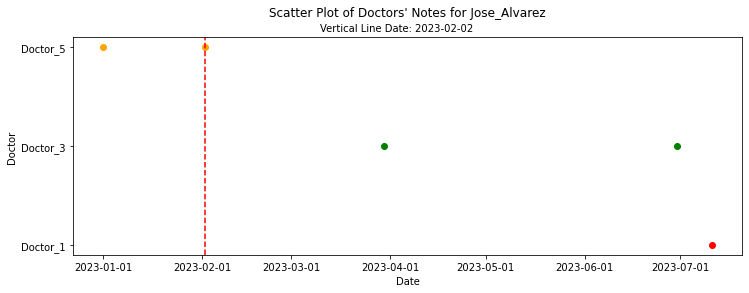

In [22]:
# Example usage:
print(f'Last note from {name_of_doctor} was:  {date_of_last_note}')
print(f'Notes since that time')
after_date = date_of_last_note #datetime.date(2023, 3, 15)  # Specify the date after which notes should be concatenated
notes_string = concatenate_notes_after_date(dict_of_notes, after_date)
print(notes_string)
# vertical_line_date = after_date # datetime.datetime.strptime(after_date, date_format)
# print(vertical_line_date)


date_line = after_date.strftime('%b %d %Y')
scatter_plot_show_dates_notes(df_doctors_notes, 
                              patient_name,
                              color_map,
                              date_line)
# scatter_plot_show_dates_notes(df_doctors_notes, vertical_line_date)

In [24]:
print(notes_string)
print()
notes_string

#####2023-03-30#####Doctor_3#####Name: Jose Alvarez
Doctor : Doctor_3
Age: 62
Gender: Male
Date of Visit: Mar 30, 2023

Chief Complaint:
Rosacea

History of Present Illness:
Mr. Alvarez is a 62-year-old male with a known history of chronic obstructive pulmonary disease (COPD)
He has experienced some recent facial flushing and has noticed some Small blood vessels on the side of his nose.


Past Medical History:

COPD: Diagnosed 10 years ago, classified as GOLD Stage II. He has a history of exacerbations in the past, managed with short-acting bronchodilators and oral corticosteroids.
Hypertension: Well-controlled on lisinopril 10 mg daily.
Hyperlipidemia: Well-controlled on atorvastatin 20 mg daily.
Gastroesophageal Reflux Disease (GERD): Managed with lifestyle modifications and as-needed antacids.
Type 2 Diabetes: Diet-controlled.

Social History:
Mr. Alvarez has a significant smoking history, having quit smoking 5 years ago after the COPD diagnosis. He denies any alcohol or illicit dru

'#####2023-03-30#####Doctor_3#####Name: Jose Alvarez\nDoctor : Doctor_3\nAge: 62\nGender: Male\nDate of Visit: Mar 30, 2023\n\nChief Complaint:\nRosacea\n\nHistory of Present Illness:\nMr. Alvarez is a 62-year-old male with a known history of chronic obstructive pulmonary disease (COPD)\nHe has experienced some recent facial flushing and has noticed some Small blood vessels on the side of his nose.\n\n\nPast Medical History:\n\nCOPD: Diagnosed 10 years ago, classified as GOLD Stage II. He has a history of exacerbations in the past, managed with short-acting bronchodilators and oral corticosteroids.\nHypertension: Well-controlled on lisinopril 10 mg daily.\nHyperlipidemia: Well-controlled on atorvastatin 20 mg daily.\nGastroesophageal Reflux Disease (GERD): Managed with lifestyle modifications and as-needed antacids.\nType 2 Diabetes: Diet-controlled.\n\nSocial History:\nMr. Alvarez has a significant smoking history, having quit smoking 5 years ago after the COPD diagnosis. He denies an

# AT THIS POINT - We start with chatGPT API
**At this point:**  
We have determined the date of the last note by the doctor in question and have the notes that follow that.

Note the line <span style="color:red">**I will start him on Doxycycline 50 mg bid for his rosacea** </span>.


In [25]:
new_notes_string = notes_string.replace('#####',"####")
print(new_notes_string.split('I will start him on Doxycycline 50 mg bid for his rosacea')[0])
print('\033[91m'+ '\033[1m' + 'I will start him on Doxycycline 50 mg bid for his rosacea' + '\033[0m')
\
 
print(new_notes_string.split('I will start him on Doxycycline 50 mg bid for his rosacea')[1])

####2023-03-30####Doctor_3####Name: Jose Alvarez
Doctor : Doctor_3
Age: 62
Gender: Male
Date of Visit: Mar 30, 2023

Chief Complaint:
Rosacea

History of Present Illness:
Mr. Alvarez is a 62-year-old male with a known history of chronic obstructive pulmonary disease (COPD)
He has experienced some recent facial flushing and has noticed some Small blood vessels on the side of his nose.


Past Medical History:

COPD: Diagnosed 10 years ago, classified as GOLD Stage II. He has a history of exacerbations in the past, managed with short-acting bronchodilators and oral corticosteroids.
Hypertension: Well-controlled on lisinopril 10 mg daily.
Hyperlipidemia: Well-controlled on atorvastatin 20 mg daily.
Gastroesophageal Reflux Disease (GERD): Managed with lifestyle modifications and as-needed antacids.
Type 2 Diabetes: Diet-controlled.

Social History:
Mr. Alvarez has a significant smoking history, having quit smoking 5 years ago after the COPD diagnosis. He denies any alcohol or illicit drug u

In [26]:

url_chatGPT_usage = 'https://platform.openai.com/account/usage'
webbrowser.open_new(url_chatGPT_usage)


True

## Prompt 0


Acting as a medical record abstractor, 
your task is to extract relevant information 
from a series of clinical notes written
by different doctors on different visits to the health center.

From the compilation of notes below, 
delimited by triple quotes
extract the information relevant to the patient's condition. 

List the dates of visits in chronological order and
include a summary of the visit including the date,
which doctor was present and what was the diagnosis
in the following format:

Visit # 1 - include the date
    Doctor:
    Diagnosis:
    Medications: List each medication on a separate line

Visit # 2 - include the date
    Doctor:
    Diagnosis:
    Medications: List each medication on a separate line
Visit # N - include the date
    Doctor:
    Diagnosis:
    Medications: List each medication on a separate line
    
    



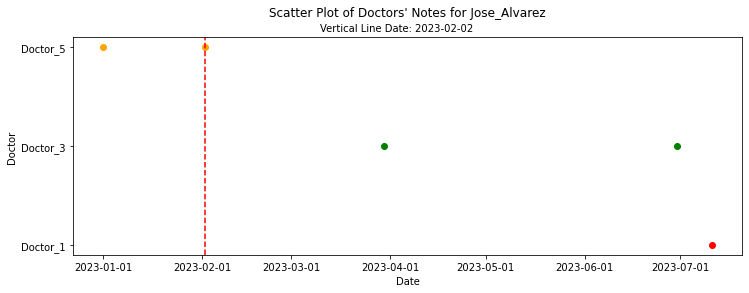

,Doctor,Date
2,Doctor_3,2023-03-30
3,Doctor_3,2023-06-30
4,Doctor_1,2023-07-11


START QUERY


Sat, 15  Jul 2023 07:44:04 DEBUG    scatter


Visit # 1 - Mar 30, 2023
    Doctor: Doctor_3
    Diagnosis: Rosacea
    Medications: 
    - Lisinopril 10 mg daily for hypertension
    - Atorvastatin 20 mg daily for hyperlipidemia
    - Doxycycline 50 mg bid for rosacea

Visit # 2 - Jun 30, 2023
    Doctor: Doctor_3
    Diagnosis: Follow up for rosacea
    Medications: 
    - Lisinopril 10 mg daily for hypertension
    - Atorvastatin 20 mg daily for hyperlipidemia
    - Doxycycline 50 mg bid for rosacea

Visit # 3 - Jul 11, 2023
    Doctor: Doctor_1
    Diagnosis: Annual physical examination
    Medications: 
    - Lisinopril 10 mg daily for hypertension
    - Atorvastatin 20 mg daily for hyperlipidemia
    - Doxycycline 50 mg bid for rosacea 


Time to Execute Task
Start  : 07:43:56
End    : 07:44:04
Elapsed: 8.147 seconds


Token Usage:
Cost to run query is based on token usage, which is $0.002 / 1K tokens
Completion tokens:        231
Prompt tokens    :      1,192
Total tokens     :      1,423
Cost to run query: $0.003


In [58]:
delimiter = '####'
prompt_0 = f"""
Acting as a medical record abstractor, \nyour task is to extract relevant information \nfrom a series of clinical notes written\nby different doctors on different visits to the health center.

From the compilation of notes below, \ndelimited by triple quotes\nextract the information relevant to the patient's condition. 

List the dates of visits in chronological order and\ninclude a summary of the visit including the date,\nwhich doctor was present and what was the diagnosis
in the following format:

Visit # 1 - include the date
    Doctor:
    Diagnosis:
    Medications: List each medication on a separate line

Visit # 2 - include the date
    Doctor:
    Diagnosis:
    Medications: List each medication on a separate line
Visit # N - include the date
    Doctor:
    Diagnosis:
    Medications: List each medication on a separate line
    
    
Review: ```{new_notes_string}```

    """

print(prompt_0.split('Review')[0])

# vertical_line_date = datetime.datetime.strptime(date_string, date_format)
vertical_line_date = date_of_last_note
date_line = date_of_last_note.strftime('%b %d %Y')
logging.getLogger().setLevel(logging.ERROR)
scatter_plot_show_dates_notes(df_doctors_notes, 
                              patient_name,
                              color_map,
                              date_line)



df_doctors_notes = df_doctors_notes.sort_values(['Date'], ascending=[True])
df_doctors_notes = df_doctors_notes.reset_index(drop=True)
mask = df_doctors_notes['Date'] > date_of_last_note
df_doctors_notes[mask]
response = get_completion_from_messages_FULL_and_costs(prompt_0)
logging.getLogger().setLevel(logging.DEBUG)
logging.debug(f'scatter')


## Prompt 1 - one additional instruction
- Be sure not to list any medications that are being initiated during a visit
- Be sure not to list any medications that the patient will be started on during a visit
 <div class="alert alert-block alert-warning">
One additional line added

</div>
    Be sure not to list any medications that the patient will be started on during a visit


In [59]:
delimiter = '####'
prompt_1 = f"""
Acting as a medical record abstractor, \nyour task is to extract relevant information \nfrom a series of clinical notes written\nby different doctors on different visits to the health center.

From the compilation of notes below, \ndelimited by triple quotes\nextract the information relevant to the patient's condition. 

List the dates of visits in chronological order and\ninclude a summary of the visit including the date,\nwhich doctor was present and what was the diagnosis
in the following format:

Visit # 1 - include the date
    Doctor:
    Diagnosis:
    Medications: List each medication on a separate line

Visit # 2 - include the date
    Doctor:
    Diagnosis:
    Medications: List each medication on a separate line
Visit # N - include the date
    Doctor:
    Diagnosis:
    Medications: List each medication on a separate line

Be sure not to list any medications that the patient will be started on during a visit

Review: ```{new_notes_string}```

    """

string = 'Be sure not to list any medications that the patient will be started on during a visit'
red_bold_string = '\033[91m'+ '\033[1m' + string+ '\033[0m'
prompt_1 = prompt_1.replace(string,red_bold_string)
print(prompt_1.split('Review')[0])

vertical_line_date = date_of_last_note


Acting as a medical record abstractor, 
your task is to extract relevant information 
from a series of clinical notes written
by different doctors on different visits to the health center.

From the compilation of notes below, 
delimited by triple quotes
extract the information relevant to the patient's condition. 

List the dates of visits in chronological order and
include a summary of the visit including the date,
which doctor was present and what was the diagnosis
in the following format:

Visit # 1 - include the date
    Doctor:
    Diagnosis:
    Medications: List each medication on a separate line

Visit # 2 - include the date
    Doctor:
    Diagnosis:
    Medications: List each medication on a separate line
Visit # N - include the date
    Doctor:
    Diagnosis:
    Medications: List each medication on a separate line

Be sure not to list any medications that the patient will be started on during a visit




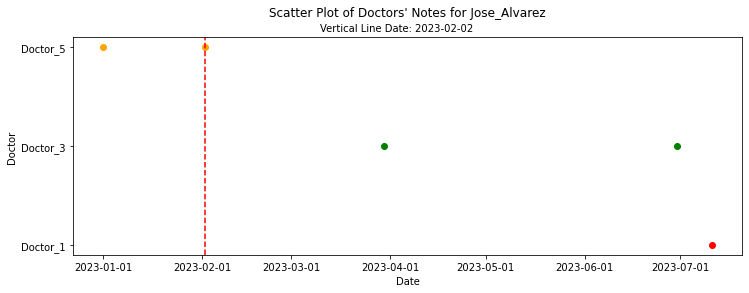

Index(['Doctor', 'Date'], dtype='object')


,Doctor,Date
2,Doctor_3,2023-03-30
3,Doctor_3,2023-06-30
4,Doctor_1,2023-07-11


START QUERY


Sat, 15  Jul 2023 07:49:58 DEBUG    scatter


Visit # 1 - Mar 30, 2023
    Doctor: Doctor_3
    Diagnosis: Rosacea
    Medications: 
    - Lisinopril 10 mg daily for hypertension
    - Atorvastatin 20 mg daily for hyperlipidemia

Visit # 2 - Jun 30, 2023
    Doctor: Doctor_3
    Diagnosis: Follow up for rosacea
    Medications: 
    - Lisinopril 10 mg daily for hypertension
    - Atorvastatin 20 mg daily for hyperlipidemia
    - Doxycycline 50 mg bid for rosacea

Visit # 3 - Jul 11, 2023
    Doctor: Doctor_1
    Diagnosis: Annual physical examination
    Medications: 
    - Lisinopril 10 mg daily for hypertension
    - Atorvastatin 20 mg daily for hyperlipidemia
    - Doxycycline 50 mg bid for rosacea 


Time to Execute Task
Start  : 07:49:51
End    : 07:49:58
Elapsed: 7.81 seconds


Token Usage:
Cost to run query is based on token usage, which is $0.002 / 1K tokens
Completion tokens:        216
Prompt tokens    :      1,219
Total tokens     :      1,435
Cost to run query: $0.003


In [71]:
date_line = date_of_last_note.strftime('%b %d %Y')
logging.getLogger().setLevel(logging.ERROR)
scatter_plot_show_dates_notes(df_doctors_notes, 
                              patient_name,
                              color_map,
                              date_line)

# scatter_plot_show_dates_notes(df_doctors_notes, vertical_line_date)
print(df_doctors_notes.columns)
df_doctors_notes = df_doctors_notes.sort_values(['Date'], ascending=[True])
df_doctors_notes = df_doctors_notes.reset_index(drop=True)
mask = df_doctors_notes['Date'] > date_of_last_note
df_doctors_notes[mask]
response = get_completion_from_messages_FULL_and_costs(prompt_1)
logging.getLogger().setLevel(logging.DEBUG)
logging.debug(f'scatter')

In [62]:
# new_notes_string = new_notes_string.replace('COPD',"Patient was seen for an exacerbations of her COPD. She continues on her medication's, which are albuterol, \
# and another medication, which she cannot recall the name for.")
# new_notes_string

In [63]:
# new_notes_string = "####2023-05-10 Doctor_3####Diabetes\n####2023-05-24 \
# Doctor_4####Patient was seen for an exacerbations of her COPD. \
# She continues on her medication's, which are albuterol, and another medication, \
# which she cannot recall the name for.\n####2023-05-31 \
# Doctor_5####HTN\n####2023-06-01  Doctor_2####Hyperlipidemia\n####2023-06-16  Doctor_4####Diabetes\n"

# List Dates of Visits and with Whom 


Acting as a medical record abstractor, 
your task is to extract relevant information 
from a series of clinical notes written
by different doctors on different visits to the health center.

From the compilation of notes below, delimited by triple quotes
extract the information relevant to the patient's condition. 

List
	dates of visits in chronological order and
	display which doctor saw the patient 




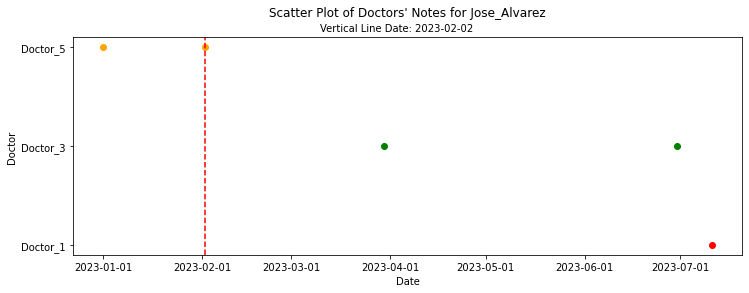

Index(['Doctor', 'Date'], dtype='object')


,Doctor,Date
2,Doctor_3,2023-03-30
3,Doctor_3,2023-06-30
4,Doctor_1,2023-07-11


START QUERY
Relevant information extracted from the clinical notes:

1. Visit on March 30, 2023:
   - Doctor: Doctor_3
   - Date of Visit: Mar 30, 2023
   - Chief Complaint: Rosacea
   - Medication: Doxycycline 50 mg bid for rosacea

2. Visit on June 30, 2023:
   - Doctor: Doctor_3
   - Date of Visit: Jun 30, 2023
   - Chief Complaint: Follow up for rosacea
   - Medication: Doxycycline 50 mg bid for rosacea

3. Visit on July 11, 2023:
   - Doctor: Doctor_1
   - Date of Visit: Jul 11, 2023
   - Chief Complaint: Annual physical examination
   - History of Present Illness: Progressive increase in dyspnea, productive cough with yellowish sputum
   - Medications: Lisinopril 10 mg daily for hypertension, Atorvastatin 20 mg daily for hyperlipidemia, Doxycycline 50 mg bid for rosacea 


Time to Execute Task
Start  : 07:52:46
End    : 07:52:54
Elapsed: 8.106 seconds


Token Usage:
Cost to run query is based on token usage, which is $0.002 / 1K tokens
Completion tokens:        242
Prompt tokens 

In [75]:
delimiter = '####'
prompt_2 = f"""
Acting as a medical record abstractor, \nyour task is to extract relevant information \nfrom a series of clinical notes written\nby different doctors on different visits to the health center.

From the compilation of notes below, \
delimited by triple quotes\nextract the information relevant to the patient's condition. 

List\n\tdates of visits in chronological order and\n\tdisplay which doctor saw the patient 

Review: ```{new_notes_string}```

    """
print(prompt_2.split('Review')[0])

# vertical_line_date = datetime.datetime.strptime(date_string, date_format)
# vertical_line_date = date_of_last_note
# print(vertical_line_date)
date_line = date_of_last_note.strftime('%b %d %Y')

logging.getLogger().setLevel(logging.ERROR)
scatter_plot_show_dates_notes(df_doctors_notes, 
                              patient_name,
                              color_map,
                              date_line)
print(df_doctors_notes.columns)
df_doctors_notes = df_doctors_notes.sort_values(['Date'], ascending=[True])
df_doctors_notes = df_doctors_notes.reset_index(drop=True)
mask = df_doctors_notes['Date'] > date_of_last_note
df_doctors_notes[mask]
response = get_completion_from_messages_FULL_and_costs(prompt_2)

# How many visits with each Doctor ?


List the doctors who saw the patient and how many visits with each doctor.




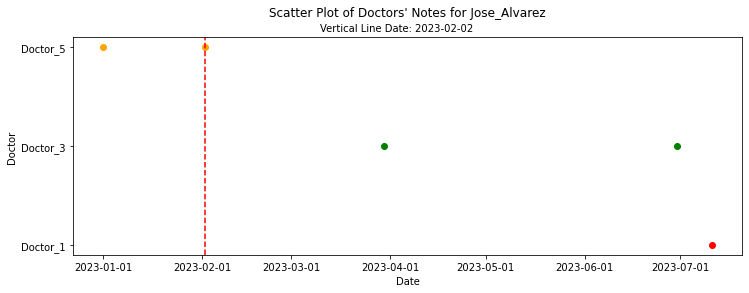

START QUERY
Doctors who saw the patient and the number of visits with each doctor:

1. Doctor_3 - 2 visits
2. Doctor_1 - 1 visit 


Time to Execute Task
Start  : 07:55:16
End    : 07:55:18
Elapsed: 1.480 seconds


Token Usage:
Cost to run query is based on token usage, which is $0.002 / 1K tokens
Completion tokens:         33
Prompt tokens    :      1,091
Total tokens     :      1,124
Cost to run query: $0.002


In [78]:
delimiter = '####'
start_query_delimiter  = '---'
prompt_3 = f"""
Acting as a medical record abstractor, \nyour task is to extract relevant information \nfrom a series of clinical notes written\nby different doctors on different visits to the health center.

From the compilation of notes below, \
delimited by triple quotes\nextract the information relevant to the patient's condition. 



{start_query_delimiter}
List the doctors who saw the patient and how many visits with each doctor.

Review: ```{new_notes_string}```

    """

print(prompt_3.split(start_query_delimiter)[1].split('Review')[0])

# vertical_line_date = datetime.datetime.strptime(date_string, date_format)
# vertical_line_date = date_of_last_note
# print(vertical_line_date)
date_line = date_of_last_note.strftime('%b %d %Y')
logging.getLogger().setLevel(logging.ERROR)
scatter_plot_show_dates_notes(df_doctors_notes, 
                              patient_name,
                              color_map,
                            date_line)
# print(df_doctors_notes.columns)
df_doctors_notes = df_doctors_notes.sort_values(['Date'], ascending=[True])
df_doctors_notes = df_doctors_notes.reset_index(drop=True)
response = get_completion_from_messages_FULL_and_costs(prompt_3)

# Stopping Here

## Generate Random Dates

In [79]:
import random
from datetime import datetime, timedelta

def generate_random_dates(num_dates, start_date, end_date):
    date_format = "%b %d %Y"
    date_list = []
    start_date = datetime.strptime(start_date, date_format)
    today = datetime.today()
    formatted_date = today.strftime("%b %d %Y")
    end_date = formatted_date
    end_date =   datetime.strptime(end_date, date_format)

    for _ in range(num_dates):
        random_date = start_date + timedelta(days=random.randint(0, (end_date - start_date).days))
        date_list.append(random_date.strftime(date_format))

    return date_list

# Example usage
random_dates = generate_random_dates(3, "Jan 1 2023", "Dec 31 2023")
print("Random Dates:", random_dates)


Random Dates: ['Jun 13 2023', 'Jan 29 2023', 'Jan 07 2023']


In [154]:
# generated_notes

[{'Name': 'Doctor_1',
  'Notes': [{'Date': datetime.date(2023, 1, 29), 'Note_contents': 'CHF'},
   {'Date': datetime.date(2023, 3, 12), 'Note_contents': 'COPD'},
   {'Date': datetime.date(2023, 2, 27), 'Note_contents': 'COPD'},
   {'Date': datetime.date(2023, 1, 27), 'Note_contents': 'Diabetes'}]},
 {'Name': 'Doctor_2',
  'Notes': [{'Date': datetime.date(2023, 6, 1),
    'Note_contents': 'Hyperlipidemia'},
   {'Date': datetime.date(2023, 1, 9), 'Note_contents': 'CHF'}]},
 {'Name': 'Doctor_3',
  'Notes': [{'Date': datetime.date(2023, 2, 25), 'Note_contents': 'COPD'},
   {'Date': datetime.date(2023, 5, 10), 'Note_contents': 'Diabetes'}]},
 {'Name': 'Doctor_4',
  'Notes': [{'Date': datetime.date(2023, 5, 24), 'Note_contents': 'COPD'},
   {'Date': datetime.date(2023, 6, 16), 'Note_contents': 'Diabetes'}]},
 {'Name': 'Doctor_5',
  'Notes': [{'Date': datetime.date(2023, 2, 26),
    'Note_contents': 'Hyperlipidemia'},
   {'Date': datetime.date(2023, 5, 31), 'Note_contents': 'HTN'},
   {'Date'

In [25]:
# def find_notes_after_date(doctors_notes, 
#                           name_of_doctor, 
#                           date_of_note):
#     dates_after_note = []
#     for doctor in doctors_notes:
#         if doctor["Name"] == name_of_doctor:
#             for note in doctor["Notes"]:
#                 if note["Date"] > date_of_note:
#                     dates_after_note.append(note["Date"])
#     return dates_after_note


def find_notes_after_date_by_specific_doctor(doctors_notes, 
                                             name_of_doctor, 
                                             date_of_note):
    dates_of_note_after_given_date = []
    for doctor in doctors_notes:
        if doctor["Name"] == name_of_doctor:
            for note in doctor["Notes"]:
                if note["Date"] > date_of_note:
                    dates_of_note_after_given_date.append(note["Date"])
    return dates_of_note_after_given_date

## Find Notes From Doctor X


In [3]:
def find_notes_from_Doctor_X(list_of_doctors_notes,name_of_doctor):
    #  generated_notes
    for doctor in list_of_doctors_notes:
        # print(doctor)
        # print()
        if doctor["Name"] == name_of_doctor:
            list_of_notes_from_doctor = doctor["Notes"]
            num_of_notes = len(list_of_notes_from_doctor)
            # for note in list_of_notes_from_doctor:
            #     print(note)
            
            sorted_list_of_notes_from_doctor = sorted(list_of_notes_from_doctor, key=lambda x: x["Date"])

            for note in sorted_list_of_notes_from_doctor:
                for i in range(num_of_notes):
                    print(f"{sorted_list_of_notes_from_doctor[i]['Date']}" )
                    print(f"\t\t{sorted_list_of_notes_from_doctor[i]['Note_contents']}" )
                    
                    print()
                break
    return sorted_list_of_notes_from_doctor

In [4]:
name_of_doctor = 'Doctor_1'
sorted_list_of_notes_from_doctor = find_notes_from_Doctor_X(generated_notes,name_of_doctor)
dates = [i['Date'] for i in sorted_list_of_notes_from_doctor]
date_of_last_note = np.max(dates)
print(f'Last Note by {name_of_doctor}:  {date_of_last_note}')
type(date_of_last_note)
type(dates[0])
sorted_list_of_notes_from_doctor

NameError: name 'generated_notes' is not defined

In [5]:
generated_notes

NameError: name 'generated_notes' is not defined

In [127]:
# import datetime

def concatenate_notes_after_date(data, after_date):
    concatenated_string = ""
    delimiter = '#####'
    sorted_notes = []
    
    for doctor in data:
        doctor_name = doctor['Name']
        for note in doctor['Notes']:
            note_date = note['Date']
            note_contents = note['Note_contents']
            
            if note_date > after_date:
                sorted_notes.append((note_date, doctor_name, note_contents))
    
    sorted_notes.sort(key=lambda x: x[0])  # Sort the notes by date
    
    for note_date, doctor_name, note_contents in sorted_notes:
        concatenated_string += f"{delimiter}{note_date}{delimiter}{doctor_name}{delimiter}{note_contents}\n"
    
    return concatenated_string

# Example usage:
after_date = date_of_last_note #datetime.date(2023, 3, 15)  # Specify the date after which notes should be concatenated
notes_string = concatenate_notes_after_date(generated_notes, after_date)
print(notes_string)
vertical_line_date = datetime.datetime.strptime(after_date, date_format)
# print(vertical_line_date)

scatter_plot_show_dates_notes(df_doctor_notes, vertical_line_date)


#####2023-05-10#####Doctor_3#####Diabetes
#####2023-05-24#####Doctor_4#####COPD
#####2023-05-31#####Doctor_5#####HTN
#####2023-06-01#####Doctor_2#####Hyperlipidemia
#####2023-06-16#####Doctor_4#####Diabetes



TypeError: strptime() argument 1 must be str, not datetime.date

In [353]:
import datetime

def concatenate_notes_after_date(data, after_date):
    concatenated_string = ""
    delimiter = '#####'
    sorted_notes = []
    
    for doctor in data:
        doctor_name = doctor['Name']
        for note in doctor['Notes']:
            note_date = note['Date']
            note_contents = note['Note_contents']
            
            if note_date > after_date:
                sorted_notes.append((note_date, doctor_name, note_contents))
    
    sorted_notes.sort(key=lambda x: x[0])  # Sort the notes by date
    
    for note_date, doctor_name, note_contents in sorted_notes:
        concatenated_string += f"{delimiter}{note_date}{delimiter}{doctor_name}{delimiter}{note_contents}\n"
    
    return concatenated_string

# Example usage:
after_date = datetime.date(2023, 3, 15)  # Specify the date after which notes should be concatenated
notes_string = concatenate_notes_after_date(generated_notes, after_date)
print(notes_string)


#####2023-03-23#####Doctor_4#####Diabetes
#####2023-04-24#####Doctor_1#####Diabetes
#####2023-05-02#####Doctor_2#####Hyperlipidemia
#####2023-05-05#####Doctor_3#####COPD
#####2023-05-10#####Doctor_1#####Hyperlipidemia
#####2023-05-21#####Doctor_1#####Hyperlipidemia



{'DATE': datetime.date(2023, 3, 6), 'Name': 'Doctor_2'}
{'DATE': datetime.date(2023, 3, 9), 'Name': 'Doctor_4'}
{'DATE': datetime.date(2023, 3, 10), 'Name': 'Doctor_2'}
{'DATE': datetime.date(2023, 3, 17), 'Name': 'Doctor_3'}
{'DATE': datetime.date(2023, 4, 9), 'Name': 'Doctor_1'}
{'DATE': datetime.date(2023, 6, 2), 'Name': 'Doctor_1'}
{'DATE': datetime.date(2023, 6, 2), 'Name': 'Doctor_1'}
{'DATE': datetime.date(2023, 6, 10), 'Name': 'Doctor_5'}
{'DATE': datetime.date(2023, 6, 13), 'Name': 'Doctor_5'}
{'DATE': datetime.date(2023, 6, 24), 'Name': 'Doctor_2'}


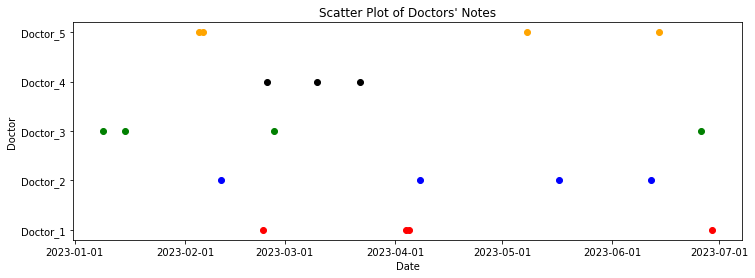

In [346]:
# def create_scatter_plot(dataframe, vertical_line_date=None):
#     plt.figure(figsize=(8, 6))

#     ax = plt.gca()  # Get the current axes
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Set the date format

#     for doctor, color in color_map.items():
#         doctor_data = dataframe[dataframe["Doctor"] == doctor]
#         dates = pd.to_datetime(doctor_data["Date"])
#         plt.scatter(dates, [doctor] * len(dates), color=color, label=doctor)

#     if vertical_line_date is not None:
#         plt.axvline(x=vertical_line_date, color='red', linestyle='--', label='Vertical Line')

#     plt.xlabel("Date")
#     plt.ylabel("Doctor")
#     plt.title("Scatter Plot of Doctors' Notes")
#     plt.legend()
#     plt.show()

# # Example usage:
# # Assuming df is the dataframe consisting of "Doctor" and "Date" columns
# vertical_date = pd.to_datetime("2023-04-15")  # Specify the date for the vertical line
# create_scatter_plot(df_doctor_notes, vertical_line_date=vertical_date)


In [ ]:
scatter_plot_show_dates_notes(df_doctor_notes)

name_of_doctor = 'Doctor_5'
date_of_note = datetime.date(2023, 1, 2)

for  name_of_doctor in list_of_doctors:
    print(f'\nDoctor {name_of_doctor}')
    dates_of_note_after_given_date = \
    find_notes_after_date_by_specific_doctor(generated_notes, name_of_doctor, date_of_note)
    dates_of_note_after_given_date.sort()
    dates_of_note_after_given_date    
    for date in dates_of_note_after_given_date:
        print(date)

In [187]:
for doctor in generated_notes:
    print(doctor['Name'])
    for note in doctor['Notes']:
        print(note)

Doctor_1
{'Date': datetime.date(2023, 4, 19), 'Note_contents': 'Hyperlipidemia'}
{'Date': datetime.date(2023, 4, 30), 'Note_contents': 'CHF'}
{'Date': datetime.date(2023, 6, 22), 'Note_contents': 'CHF'}
Doctor_2
{'Date': datetime.date(2023, 4, 14), 'Note_contents': 'HTN'}
{'Date': datetime.date(2023, 1, 28), 'Note_contents': 'COPD'}
Doctor_3
{'Date': datetime.date(2023, 2, 18), 'Note_contents': 'Diabetes'}
{'Date': datetime.date(2023, 4, 25), 'Note_contents': 'COPD'}
Doctor_4
{'Date': datetime.date(2023, 2, 16), 'Note_contents': 'HTN'}
{'Date': datetime.date(2023, 4, 29), 'Note_contents': 'COPD'}
{'Date': datetime.date(2023, 1, 20), 'Note_contents': 'Hyperlipidemia'}
Doctor_5
{'Date': datetime.date(2023, 1, 26), 'Note_contents': 'CHF'}
{'Date': datetime.date(2023, 6, 16), 'Note_contents': 'Diabetes'}
{'Date': datetime.date(2023, 1, 4), 'Note_contents': 'CHF'}
{'Date': datetime.date(2023, 3, 2), 'Note_contents': 'COPD'}


In [182]:
import random

def generate_doctors(num_doctors):
    doctors = []
    names_set = set()

    while len(doctors) < num_doctors:
        doctor_number = random.randint(1, num_doctors)
        name = f"Doctor_{doctor_number}"
        if name not in names_set:
            names_set.add(name)
            doctor = {
                "Name": name,
                "Notes": []
            }
            doctors.append(doctor)

    return doctors

# Example usage
num_doctors = 5
doctors_list = generate_doctors(num_doctors)
print(doctors_list)


[{'Name': 'Doctor_1', 'Notes': []}, {'Name': 'Doctor_3', 'Notes': []}, {'Name': 'Doctor_5', 'Notes': []}, {'Name': 'Doctor_2', 'Notes': []}, {'Name': 'Doctor_4', 'Notes': []}]


In [183]:
def find_index_by_name(doctors_list, name):
    for index, doctor in enumerate(doctors_list):
        if doctor["Name"] == name:
            return index
    return -1
name = 'Doctor_3'
index = find_index_by_name(doctors_list, name)

if index != -1:
    print(f"Index of {name}: {index}")
else:
    print(f"{name} not found in the list.")


Index of Doctor_3: 1


**Let's start off with a dict of doctors**

In [ ]:
dict_of_my_generated_notes = {}
list_of_dict_of_my_generated_notes = []
# dict_of_my_generated_notes['Name']

In [184]:
# take some dates and create some notes
list_current_notes = []
for date in ['Jan 30 2023','Feb 2 2023','Mar 30 2023']:
    
    parsed_date = parse_date(date) #datetime.date format
    
    note_date = parsed_date
    date_for_file_name = parsed_date.strftime('%Y_%m_%d')
    
    print(date_for_file_name , date_for_file_name.replace('_','-')) # replacing name to use in file name
    working_note = current_note.replace('Feb 11',date.split(' 2023')[0]) # replace date of visit
    
    random_num_for_doctor = random.randint(1, 5)  # Generate a random number for doctor
    replacement_doctor = 'Doctor_' + str(random_num_for_doctor)
    print(f'found {doctor_of_visit } replacing with {random_num_for_doctor}')
    # for i in range(len(doctors_list)): # can do better her
    #     if doctors_list[i] == 'Doctor_' + random_num_for_doctor:
    #         doctors_list[i]['']
    working_note = current_note.replace(doctor_of_visit, replacement_doctor   ) # replace doctor number in note
       
    
    index_in_doctors_list = find_index_by_name(doctors_list, replacement_doctor)
    'index', index_in_doctors_list
    print(doctors_list[index_in_doctors_list]['Name'])
    
    
    # Add note to Notes
    
    
    doctors_list[index_in_doctors_list]['Notes']= {'Note_contents': '','Date': None}
    doctors_list[index_in_doctors_list]['Notes']['Note_contents'] = working_note
    doctors_list[index_in_doctors_list]['Notes']['Date'] = note_date
    
    file_name_to_write = patient_name + '_' + date_for_file_name + '.txt'
    file_name_to_write
    with open( os.path.join(dir_pt_notes,file_name_to_write), 'w') as file:
        file.write(working_note)
# doctors_list

2023_01_30 2023-01-30
found Doctor_1 replacing with 5


('index', 2)

Doctor_5


'John Smith_2023_01_30.txt'

4070

2023_02_02 2023-02-02
found Doctor_1 replacing with 2


('index', 3)

Doctor_2


'John Smith_2023_02_02.txt'

4070

2023_03_30 2023-03-30
found Doctor_1 replacing with 3


('index', 1)

Doctor_3


'John Smith_2023_03_30.txt'

4070


# End

In [ ]:
#                     lines = content.split('\n')
#                     print(lines)
#                     output_lines = []
#                     for line in lines:
#                         if ':' in line:
#                             line_parts = line.split(':')
#                             condition = line_parts[0].strip()
#                             output_lines.append(condition + ': ...')
#                         else:
#                             output_lines.append(line)

#                     output_string = '\n'.join(output_lines)
#                     print(output_string)
                    
                    

# Example usage:
# doctors_list = [
#     {
#         "Name": "Doctor_1",
#         "Notes": [
#             {"Date": datetime.date(2023, 3, 1), "Note_contents": "Some note"},
#             {"Date": datetime.date(2023, 4, 15), "Note_contents": "Some note"},
#             {"Date": datetime.date(2023, 6, 20), "Note_contents": "Some note"}
#         ]
#     },
#     {
#         "Name": "Doctor_2",
#         "Notes": [
#             {"Date": datetime.date(2023, 2, 5), "Note_contents": "Some note"},
#             {"Date": datetime.date(2023, 5, 10), "Note_contents": "Some note"},
#             {"Date": datetime.date(2023, 7, 5), "Note_contents": "Some note"}
#         ]
#     }
# ]

# df = create_doctor_date_dataframe(dict_of_notes, doctors_list)
# print(df)

In [ ]:
# def concatenate_notes_after_last_note_using_df (data, after_date):
#     # data is a dict of all the notes
#     # we could just go throuh the df for dates and then would not need to sort
    
#     # Could also just go through the dates in the df and look for those notes
    
    
#     concatenated_string = ""
#     delimiter = '#####'
#     sorted_notes = []
    
#     for doctor,value  in dict_of_notes.items():
#         print(doctor)
#         num_of_notes = len(dict_of_notes[doctor]['Notes'])
#         for a_note in dict_of_notes[doctor]['Notes']:
#             print(a_note['Date'])
#             print(f"\t\tThe Note:\n{a_note['Content']}")
#             note_date = a_note['Date']
#             note_contents = a_note['Content']
            
#             if note_date > after_date:
#                 sorted_notes.append((note_date, doctor, note_contents))
    
#             print('---------------------------------------------------------------')

        
           
    
    
    
#     sorted_notes.sort(key=lambda x: x[0])  # Sort the notes by date

#     for note_date, doctor_name, note_contents in sorted_notes:
#         concatenated_string += f"{delimiter}{note_date}{delimiter}{doctor_name}{delimiter}{note_contents}\n"

#     return concatenated_string

In [ ]:
# def find_notes_from_Doctor_X(list_of_doctors_notes,name_of_doctor):
#     #  generated_notes
#     for doctor in list_of_doctors_notes:
#         # print(doctor)
#         # print()
#         if doctor["Name"] == name_of_doctor:
#             list_of_notes_from_doctor = doctor["Notes"]
#             num_of_notes = len(list_of_notes_from_doctor)
#             # for note in list_of_notes_from_doctor:
#             #     print(note)
            
#             sorted_list_of_notes_from_doctor = sorted(list_of_notes_from_doctor, key=lambda x: x["Date"])

#             for note in sorted_list_of_notes_from_doctor:
#                 for i in range(num_of_notes):
#                     print(f"{sorted_list_of_notes_from_doctor[i]['Date']}" )
#                     print(f"\t\t{sorted_list_of_notes_from_doctor[i]['Note_contents']}" )
                    
#                     print()
#                 break
#     return sorted_list_of_notes_from_doctor

In [ ]:
dict_of_notes.keys()
def get_values_by_key(data_list, key):
    print(data_list)
    values = []
    for item in data_list:
        print(f'item {item}')
        if key in item:
            values.append(item[key])
    return values



data_list = [
    {'Name': 'John', 'Age': 30},
    {'Name': 'Jane', 'Age': 25},
    {'Name': 'Bob', 'Age': 40},
    {'Name': 'Alice', 'Age': 35},
    {'Name': 'Charlie'}
]

key = 'Name'
# values = get_values_by_key(data_list, key)
values = get_values_by_key(list_of_pt_notes, key)

if len(values) > 0:
    print(f"Values for key '{key}': {values}")
else:
    print(f"No values found for key '{key}'")


In [10]:
generated_notes = generate_list_of_doctors_notes()
generated_notes

[{'Name': 'Doctor_1',
  'Notes': [{'Date': datetime.date(2023, 1, 29), 'Note_contents': 'CHF'},
   {'Date': datetime.date(2023, 3, 12), 'Note_contents': 'COPD'},
   {'Date': datetime.date(2023, 2, 27), 'Note_contents': 'COPD'},
   {'Date': datetime.date(2023, 1, 27), 'Note_contents': 'Diabetes'}]},
 {'Name': 'Doctor_2',
  'Notes': [{'Date': datetime.date(2023, 6, 1),
    'Note_contents': 'Hyperlipidemia'},
   {'Date': datetime.date(2023, 1, 9), 'Note_contents': 'CHF'}]},
 {'Name': 'Doctor_3',
  'Notes': [{'Date': datetime.date(2023, 2, 25), 'Note_contents': 'COPD'},
   {'Date': datetime.date(2023, 5, 10), 'Note_contents': 'Diabetes'}]},
 {'Name': 'Doctor_4',
  'Notes': [{'Date': datetime.date(2023, 5, 24), 'Note_contents': 'COPD'},
   {'Date': datetime.date(2023, 6, 16), 'Note_contents': 'Diabetes'}]},
 {'Name': 'Doctor_5',
  'Notes': [{'Date': datetime.date(2023, 2, 26),
    'Note_contents': 'Hyperlipidemia'},
   {'Date': datetime.date(2023, 5, 31), 'Note_contents': 'HTN'},
   {'Date'